# 掃Gate量IV 

In [14]:
import numpy as np
import pandas as pd
import pyvisa as visa
import matplotlib.pyplot as plt
import os, time, threading, datetime, pymeasure,tqdm
from tqdm import trange,tqdm
from time import sleep
from datetime import date
from IPython import display
from scipy.optimize import curve_fit
from pymeasure.adapters import VISAAdapter
from pathlib import Path
from pymeasure.instruments.keithley import Keithley2400, Keithley2000
import qcodes.instrument_drivers.oxford.MercuryiPS_VISA as mercury_ips
current_work_directory = os.getcwd()
os.chdir('C:/Users/USER/Device_Library/Device_Library/')
from my_SR830 import my_SR830
from my_K213 import my_K213
import device_query
os.chdir(current_work_directory)
now = datetime.datetime.now()
# print(now.strftime("%Y-%m-%d %H:%M:%S"))

In [15]:
visa.ResourceManager().list_resources()

('ASRL1::INSTR',
 'ASRL2::INSTR',
 'ASRL10::INSTR',
 'GPIB0::5::INSTR',
 'GPIB0::18::INSTR')

In [16]:
def GOTO_THREAD(K213, port_id, target, time_shift):
    print("Port ID = %d , target = %.4f ."%(port_id, target))
    time.sleep(time_shift)
#     K213.GOTO(target, step, delay_time, reset_range=True,auto_range=True, reset_port=True, port=port_id)  old syntax!!
    K213.GOTO(target, step, delay_time, port = port_id, reset_range=True,auto_range=True)
    K213.GET_OUTPUT(port_id)
    time.sleep(1)
    
def TO_ZERO_THREAD(K213, port_id, time_shift):
    print("Port ID = %d , target = %.4f ."%(port_id, 0.0))
    time.sleep(time_shift)
    K213.ZERO(step, delay_time, port_id)
    K213.GET_OUTPUT(port_id)
    time.sleep(1)

## 讀取830和213

In [17]:
SR830_GPIB_Addr = 5
K213_GPIB_Addr = 18
srs_source = my_SR830.MY_SR830(SR830_GPIB_Addr)
K213 = my_K213.MY_KEITHLEY213(K213_GPIB_Addr, port=1)
port_list = [1,2,3,4]  #輸入要固定的port(要同時調整的PORT)
## 1 for tuning and 2 is fixed
#[1,2,3,4] 如果多P3,P4需要當GATE

Port 1 is selected.


## 相關設定

In [18]:
gate_voltage_apply_1,n = [],'no input'

min_V = 2.5   #initial voltage
max_V = 0    #final voltage
data_points = 250  #resolution per sweep

forth = np.linspace(min_V, max_V,data_points)
back = np.flip(forth,0)
gate_voltage_apply_1 = forth

flag = input("要不要來回掃? Y/N >>> ")
if flag == 'Y':
    n = eval(input("(來回算一次，要幾次?(輸入數字 ex. 1, 2, 3, 4, ...) >>> "))
    for i in range(int(n)-1):
        gate_voltage_apply_1 = np.append(gate_voltage_apply_1,back)
        gate_voltage_apply_1 = np.append(gate_voltage_apply_1, forth)
    gate_voltage_apply_1 = np.append(gate_voltage_apply_1,back)
else:
    gate_voltage_apply_1 = forth # for 213
print("\n掃過的電壓值如下\n")
print(gate_voltage_apply_1)

#gate_voltage_apply_1 = np.linspace(min_V, max_V,data_points) # for 213 port 1
gate_voltage_apply_2 = min_V # for 213 port 2,3,4 (other gates, which are kept constant)


measure_wait_time=1  #電壓到時等一段時間穩定後再量測
step = 0.005         #調變電壓每一步的大小
delay_time = 0.1    #每次調變所等待的時間
N_ave = 10           #在一個電壓職重複量測幾次
ave_wait = 1         #Lock-in 要等0.5秒才能再量

#畫圖
fontsize = 8
drawing_resolution=10

#分壓比例(Source Drain SR830)
divider_ratio= 1e-5
#放大器比例(Source Drain SR830)
Amplifier_gain= 1e6

要不要來回掃? Y/N >>> Y
(來回算一次，要幾次?(輸入數字 ex. 1, 2, 3, 4, ...) >>> 1

掃過的電壓值如下

[2.5        2.48995984 2.47991968 2.46987952 2.45983936 2.4497992
 2.43975904 2.42971888 2.41967871 2.40963855 2.39959839 2.38955823
 2.37951807 2.36947791 2.35943775 2.34939759 2.33935743 2.32931727
 2.31927711 2.30923695 2.29919679 2.28915663 2.27911647 2.26907631
 2.25903614 2.24899598 2.23895582 2.22891566 2.2188755  2.20883534
 2.19879518 2.18875502 2.17871486 2.1686747  2.15863454 2.14859438
 2.13855422 2.12851406 2.1184739  2.10843373 2.09839357 2.08835341
 2.07831325 2.06827309 2.05823293 2.04819277 2.03815261 2.02811245
 2.01807229 2.00803213 1.99799197 1.98795181 1.97791165 1.96787149
 1.95783133 1.94779116 1.937751   1.92771084 1.91767068 1.90763052
 1.89759036 1.8875502  1.87751004 1.86746988 1.85742972 1.84738956
 1.8373494  1.82730924 1.81726908 1.80722892 1.79718876 1.78714859
 1.77710843 1.76706827 1.75702811 1.74698795 1.73694779 1.72690763
 1.71686747 1.70682731 1.69678715 1.68674699 1.67670683 1

In [19]:
print(gate_voltage_apply_1.size)

500


## 830相關設定

In [20]:
SD_voltage_apply = 1

srs_goto_step = 0.05
srs_goto_delay_time=0.5
srs_source.input_config = 'A'
srs_source.input_grounding = 'Float'
srs_source.frequency = 87.11 # change the lock-in frequency
srs_source.time_constant = 0.3 # change the lock-in time constant
srs_source.sensitivity = 1e-3 # change the lock-in sensitivity
srs_source.channel1 = 'X'
srs_source.channel2 = 'Y'

# srs_source.GOTO(SD_voltage_apply, srs_goto_step, srs_goto_delay_time)   #lockin test ramp
# Lock-in 放大率(到K2000需要乘上倍數)
# senstivity 2mv = 5000倍
# 10V / senstivity

In [21]:
#srs_source.GOTO(SD_voltage_apply, srs_goto_step, srs_goto_delay_time) #給檢查Sensitivity
#srs_source.GOTO(0.004, srs_goto_step, srs_goto_delay_time) #歸零

## 路徑設定

In [22]:
repeat = 0
pin_name = "AG2"
folder_path = "C:/Users/USER/Sean/2020-11-10 QD pinch_off/" ##儲存的地方
file_name = '%s_pinch_off_backandforth_others_at_%sV_repeat%s_at_%s'%(pin_name,gate_voltage_apply_2, repeat,date.today())##儲存的檔名

print('檔名會叫做 >> %s'%file_name) 

overwrite = 'Y'
if os.path.isfile('%s%s.txt'%(folder_path,file_name))==True:
    overwrite = input('Do you want to overwtite the existing file? >>> Y/N  ')
if overwrite == 'Y':
    file_name = file_name
else:
    file_name = '##'
    print("please create a new file")
    raise RuntimeError('!!!!  File exsit, please name a new file  !!!!')

檔名會叫做 >> AG2_pinch_off_backandforth_others_at_2.5V_repeat0_at_2020-11-13


## 213歸零

In [23]:
threads = []
shift = 4e-2 #同時給兩個port會當機所以要有一個小時間差

print("Start...")
for i in range(len(port_list)):
    time_shift = shift*i
    threads.append(threading.Thread(target = TO_ZERO_THREAD, args = (K213, port_list[i], time_shift)))
    threads[i].start()

for i in range(len(port_list)):
    threads[i].join()

print("Done!")
print('P%d is now at'%port_list[0],K213.GET_OUTPUT(port=1),'Volts')
print('P%d is now at'%port_list[1],K213.GET_OUTPUT(port=2),'Volts')
print('P%d is now at'%port_list[2],K213.GET_OUTPUT(port=3),'Volts')
print('P%d is now at'%port_list[3],K213.GET_OUTPUT(port=4),'Volts')


Start...
Port ID = 1 , target = 0.0000 .Port ID = 2 , target = 0.0000 .
Port ID = 3 , target = 0.0000 .
Port ID = 4 , target = 0.0000 .



Exception in thread Thread-20:
Traceback (most recent call last):
  File "C:\Users\USER\Anaconda3\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\USER\Anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-16-ed4b6c856ddf>", line 13, in TO_ZERO_THREAD
    K213.GET_OUTPUT(port_id)
  File "C:\Users\USER\Device_Library\Device_Library\my_K213\my_K213.py", line 51, in GET_OUTPUT
    voltage = eval(voltage)
  File "<string>", line 1
    00.00000V+00.00000
            ^
SyntaxError: invalid syntax

Exception in thread Thread-21:
Traceback (most recent call last):
  File "C:\Users\USER\Anaconda3\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\USER\Anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-16-ed4b6c856ddf>", line 12, in TO_ZERO_THREAD
    K213.ZERO(step, delay_time, port_id)
  File "C:\Users\USER\De

Done!
P1 is now at 0.0 Volts
P2 is now at 0.0 Volts
P3 is now at 0.0 Volts
P4 is now at 0.0 Volts


## 將固定電壓先給好

In [24]:
#srs_source.GOTO(SD_voltage_apply, srs_goto_step, srs_goto_delay_time)       ##### SR-830設定(固定SD)

threads = []  ###除上經過濾波器後遞減的電壓
target = [min_V/0.835,gate_voltage_apply_2/0.835,gate_voltage_apply_2/0.835,gate_voltage_apply_2/0.72] #分別目標值 (有幾個PORT打幾個)
shift = 0.1 #port 和 port之間開始便電壓的時間間隔

print("Start...")
for i in range(len(port_list)):
    time_shift = shift*i
    threads.append(threading.Thread(target = GOTO_THREAD, args = (K213, port_list[i],target[i],time_shift)))
    threads[i].start()
for i in range(len(port_list)):
    threads[i].join()
print("Done!")
print('P%d is now at'%port_list[0],K213.GET_OUTPUT(port=1),'Volts')
print('P%d is now at'%port_list[1],K213.GET_OUTPUT(port=2),'Volts')
print('P%d is now at'%port_list[2],K213.GET_OUTPUT(port=3),'Volts')
print('P%d is now at'%port_list[3],K213.GET_OUTPUT(port=4),'Volts')

Start...
Port ID = 1 , target = 2.9940 .
Port ID = 2 , target = 2.9940 .Port ID = 3 , target = 2.9940 .
Port ID = 4 , target = 3.4722 .

Done!
P1 is now at 2.99375 Volts
P2 is now at 2.99375 Volts
P3 is now at 2.99375 Volts
P4 is now at 3.47125 Volts


## 到開始量測點後開始量測

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


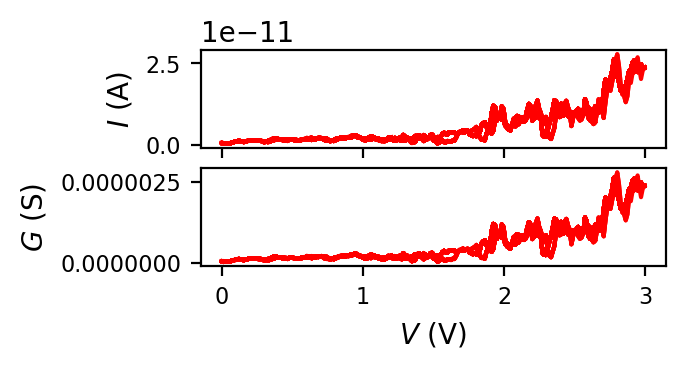

這次量測花費了 97.450044 分鐘
Source drain goes to zero...
Start...
Port ID = 1 , target = 0.0000 .
Port ID = 2 , target = 0.0000 .Port ID = 3 , target = 0.0000 .
Port ID = 4 , target = 0.0000 .

Done!
P1 is now at 0.0 Volts
P2 is now at 0.0 Volts
P3 is now at 0.0 Volts
P4 is now at 0.0 Volts


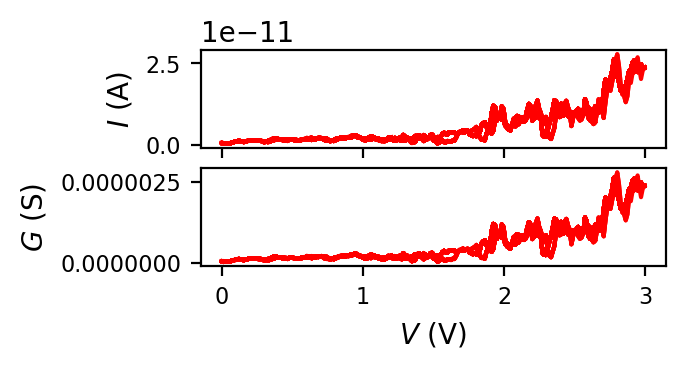

In [25]:
K213.GOTO(min_V/0.835, step, delay_time, port=1,reset_range=True, auto_range = True, range_m=1)
print("Sweeping gate goes to starting value...")
print("Initialize K213...")

current_measure_xx = np.zeros((len(gate_voltage_apply_1), N_ave+1)) #製造0矩陣以放入量測數據
conductance_measure_xx = np.zeros((len(gate_voltage_apply_1), N_ave+1))

plt.figure(figsize=(3,3), dpi=200)
plt.xlim([min_V,max_V])
    #plt.xlim([0,max_I])
    
start = time.time()
print("Apply Gate voltage...")
gate_voltage_apply_1 = gate_voltage_apply_1/0.835
for index_V, voltage in enumerate(tqdm(gate_voltage_apply_1)): #####開始掃GATE(P1)並量測記錄
        K213.GOTO(voltage, step, delay_time, port=1,\
                  reset_range=True, auto_range = True, range_m=1)
        time.sleep(measure_wait_time)
        Sum_of_current, Sum_of_conductance = 0, 0
        
    ####量測####
        for n in range(N_ave):
            current_measure_xx[index_V,n] = srs_source.x/Amplifier_gain   ##讀取Lock_in的值  絕對值:srs_source.magnitude
            conductance_measure_xx[index_V,n] = srs_source.x/Amplifier_gain/(SD_voltage_apply*divider_ratio)
            Sum_of_current += current_measure_xx[index_V,n]
            Sum_of_conductance += conductance_measure_xx[index_V,n]
            time.sleep(ave_wait)## Lockin delay 0.5s
        current_measure_xx[index_V,N_ave] = Sum_of_current/float(N_ave) #加上平均數值
        conductance_measure_xx[index_V,N_ave] = Sum_of_conductance/float(N_ave) #加上平均數值
    
    ####畫圖####
        if (index_V%drawing_resolution==0):
            display.clear_output(wait=True)
            
            plt.subplot(4,1, 1)
            plt.plot(gate_voltage_apply_1[:index_V+1] , current_measure_xx[:index_V+1,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
#           plt.ylim([voltage_measure.min(),voltage_measure.max()])
            plt.xlabel("$V$ (V)")
            plt.xticks(fontsize=fontsize)
            plt.ylabel("$I$ (A)")
            plt.yticks(fontsize=fontsize)
            
            plt.subplot(4,1, 2)
            plt.plot(gate_voltage_apply_1[:index_V+1] , conductance_measure_xx[:index_V+1,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
#           plt.ylim([voltage_measure.min(),voltage_measure.max()])
            plt.xlabel("$V$ (V)")
            plt.xticks(fontsize=fontsize)
            plt.ylabel("$G$ (S)")
            plt.yticks(fontsize=fontsize)
            display.display(plt.gcf())
#             print("Current temperature is %.4f K."%triton.GET_CURRENT_TEMPERATURE(control_channel))
time.sleep(0.01)
print("Measurement ends.")

display.clear_output(wait=True)

plt.subplot(4,1, 1)
plt.plot(gate_voltage_apply_1 , current_measure_xx[:,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
#plt.ylim([voltage_measure.min(),voltage_measure.max()])
plt.xlabel("$V$ (V)")
plt.xticks(fontsize=fontsize)
plt.ylabel("$I$ (A)")
plt.yticks(fontsize=fontsize)

plt.subplot(4,1, 2)
plt.plot(gate_voltage_apply_1 , conductance_measure_xx[:,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
#plt.ylim([voltage_measure.min(),voltage_measure.max()])
plt.xlabel("$V$ (V)")
plt.xticks(fontsize=fontsize)
plt.ylabel("$G$ (S)")
plt.yticks(fontsize=fontsize)
# plt.savefig('%s/Rxx.png'%folder_path[index_current],bbox_inches='tight', dpi=200, pad_inches=0.05) ##存圖片
display.display(plt.gcf())
stop = time.time()
T=(stop-start)/60
print('這次量測花費了 %f 分鐘'%T)

    ####歸零####
print("Source drain goes to zero...")
threads = []
shift = 4e-2 #同時給兩個port會當機所以要有一個小時間差
print("Start...")
for i in range(len(port_list)):
    time_shift = shift*i
    threads.append(threading.Thread(target = TO_ZERO_THREAD, args = (K213, port_list[i], time_shift)))
    threads[i].start()
for i in range(len(port_list)):
    threads[i].join()
print("Done!")
print('P%d is now at'%port_list[0],K213.GET_OUTPUT(port=1),'Volts')
print('P%d is now at'%port_list[1],K213.GET_OUTPUT(port=2),'Volts')
print('P%d is now at'%port_list[2],K213.GET_OUTPUT(port=3),'Volts')
print('P%d is now at'%port_list[3],K213.GET_OUTPUT(port=4),'Volts')
gate_voltage_apply_1 = gate_voltage_apply_1*0.835

In [26]:
raw_data = np.hstack((gate_voltage_apply_1.reshape(-1,1), current_measure_xx, conductance_measure_xx))
data = np.hstack((gate_voltage_apply_1.reshape(-1,1), current_measure_xx[:,[-1]], conductance_measure_xx[:,[-1]]))
np.savetxt("%sraw_data%s.txt" %(folder_path,file_name),raw_data, fmt="%.8e", \
           header='V(V)\tI(A)*%d\tI_avg\tG(S)*%d\tG_avg(S)'%(N_ave,N_ave))
np.savetxt('%s%s.txt'%(folder_path,file_name),data, fmt="%.8e",comments='',\
           header='VAG\tId_avg_of_%s\tG_avg_of_%s\
           \n(V)\t(A)\t(S)\
           \nfrom%sVto%sV\tDGs_at_%sV\t%s\tresolution_%s(V)\tmeasure_wait_time_%s\tgoto_step_%s\tdelay_time_goto_%s'\
           %(N_ave,N_ave,\
             min_V,max_V,gate_voltage_apply_2,pin_name,(max_V-min_V)/data_points,measure_wait_time,step,delay_time))


#"%s/I_V_G_V%s.txt" %(folder_path,file_name)
# print (now.strftime("%Y-%m-%d %H:%M:%S"))

# 其他量測方法

In [14]:
#         for n in range(N_ave+1):
#             if n == N_ave:
#                 current_measure_xx[index_V,n] = Sum_of_current/float(N_ave) #加上平均數值
#             else: 
#                 current_measure_xx[index_V,n] = srs_source.magnitude  ##讀取Lock_in的值
#                 Sum_of_current += current_measure_xx[index_V,n]
#                 time.sleep(srs_goto_delay_time)## Lockin delay 0.5s

# 其他存檔方法

In [15]:
# data = np.concatenate((z_range.reshape(-1,1),resistance_measure_1.reshape(-1,1),resistance_measure_2.reshape(-1,1)), axis=1) #✪measure要改   
# np.savetxt("%sGraphene_%s.txt" %(path, file_name), data, fmt="%.8e")

# with open("%sGraphene_%s.txt" %(path, annotation), 'ab') as file:
#     data = np.concatenate((z_range.reshape(-1,1),voltage_measure_1.reshape(-1,1)), axis=1) #✪measure要改   
#     np.savetxt(file, data, fmt="%.8e")

# K213其他調控方法

In [16]:
#法1
# gate_volt = k213_source_2.GET_OUTPUT(port=2)
# if gate_volt <= min(gate_voltage_apply_2,gate_voltage_apply_3):
#     while gate_volt <= min(gate_voltage_apply_2,gate_voltage_apply_3):
#         if k213_source_2.GET_OUTPUT(port=2)+step_size > gate_voltage_apply_2:
#             break
#         gate_volt+=step_size

#         k213_source_2.GOTO(gate_volt, step_size, delay_time_goto,\
#                          reset_range=True, auto_range = True, range_m=1, reset_port = True, port=2)  
#         k213_source_3.GOTO(gate_volt, step_size, delay_time_goto,\
#                          reset_range=True, auto_range = True, range_m=1, reset_port = True, port=3) 

# else:
#     while gate_volt >= min(gate_voltage_apply_2,gate_voltage_apply_3):
#         if k213_source_2.GET_OUTPUT(port=2)-step_size < gate_voltage_apply_2:
#             break
#         gate_volt+=step_size*-1

#         k213_source_2.GOTO(gate_volt, step_size, delay_time_goto,\
#                          reset_range=True, auto_range = True, range_m=1, reset_port = True, port=2)  
#         k213_source_3.GOTO(gate_volt, step_size, delay_time_goto,\
#                          reset_range=True, auto_range = True, range_m=1, reset_port = True, port=3) 






#法2
##### 213設定(固定P2,P3)
# from threading import Thread
# def func1():
#     return k213_source_2.GOTO(gate_voltage_apply_2, step_size, delay_time_goto,\
#                             reset_range=True, auto_range = True, range_m=1, reset_port = True, port=2)
# def func2():
#     return k213_source_3.GOTO(gate_voltage_apply_3, step_size, delay_time_goto,\
#                             reset_range=True, auto_range = True, range_m=1, reset_port = True, port=3)
# if __name__ == '__main__':
#     Thread(target = func1).start()
#     Thread(target = func2).start()

In [17]:
# path = 'C:/Users/LiangLab/Sean/test_data'

# #✪位✪置有更正需要改動
# try:
#     os.makedirs(path)
# except:
#     print("Directory might exists!")